## Section 2.2 - ICP applied on moderate dataset

### Imports

In [1]:
!pip install ipython-autotime 
try:
    import open3d as o3d
except ModuleNotFoundError:
    !conda install open3d
    import open3d as o3d


import copy
import numpy as np
import pandas as pd
import open3d as o3d
from tqdm import tqdm
from IPython.display import HTML
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
import matplotlib.animation as animation

%load_ext autotime

time: 0 ns (started: 2024-11-21 11:19:46 -03:00)


### Functions

In [3]:
def plot_2d(x, y, label, axis = None):
    if axis:
        ax = axis
    else:
        ax = plt.gca()
    ax.scatter(x,y, s=0.6)
    ax.set_ylim(-8, 8)
    ax.set_xlim(-8, 8)
    ax.plot(0, 0, 'ro')
    ax.set_title(label)
    ax.grid()
    ax.set_aspect('equal')
    if not axis:
        plt.show()
  
def kdtree_nearest_neighbor(P, Q):
    '''
    Find the nearest (Euclidean) neighbor in dst for each point in src by KDTree search (faster)
    Input:
        src: Nxm array of points
        dst: Nxm array of points
    Output:
        List:
          indices of point cloud P
          indices of mathced point cloud Q
          distance
    '''
    tree = KDTree(Q.T)
    p_size = P.shape[1]
    q_size = Q.shape[1]
    correspondences = []
    for i in range(p_size):
        p_point = P[:, i]
        nearest_dist, nearest_ind = tree.query([p_point], k=2)  # k=2 nearest neighbors where k1 = identity
        d = nearest_dist[:,1][0]
        j = nearest_ind[:,1][0]
        correspondences.append((i, j, d))
    return correspondences

def convert_xyz_to_pcd(input_df, output_file):
    # Pass xyz to Open3D.o3d.geometry.PointCloud and visualize
    if 'z' not in input_df.columns:
        input_df['z']=0
    if 'ones' in input_df.columns:
        del input_df['ones']
    
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(input_df.to_numpy())

    # Salvar no formato .pcd
    o3d.io.write_point_cloud(output_file, pcd)

time: 0 ns (started: 2024-11-21 11:19:51 -03:00)


### Open Dataset

In [30]:
df = pd.read_csv(f"./sample_data/t_q0_q1_q2_q3_seq_x_y_z1.csv", names=["time","q0","q1","q2","q3","seq","x","y","z"], header=None)
dfs = []
for s in df.seq.unique():
    dfs.append(df.loc[df['seq']==s])
for i in range(len(dfs)):
    del dfs[i]['time']
    del dfs[i]['seq']
    index_to_remove = dfs[i].loc[(dfs[i]['x']==0.0) & (dfs[i]['y']==0.0)].index.values
    dfs[i] = dfs[i].drop(index=index_to_remove)

time: 47 ms (started: 2024-11-21 11:33:42 -03:00)


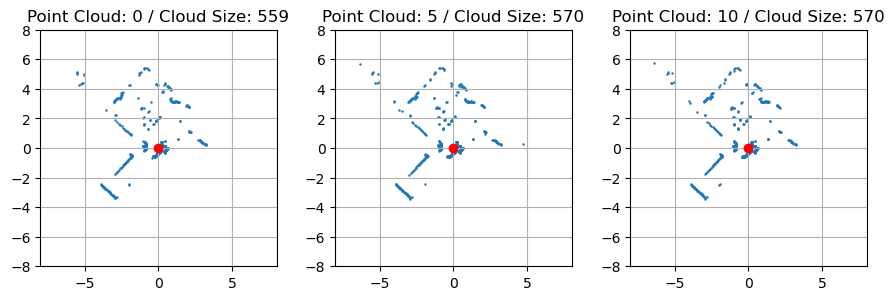

time: 281 ms (started: 2024-11-21 11:34:12 -03:00)


In [31]:
# Check different sensor responses for the same room
fig, axis = plt.subplots(1,3,figsize=(9,6))

# plot 0th point cloud
i = 0
df2 = dfs[i]
plot_2d(df2.x,df2.y,f"Point Cloud: {i} / Cloud Size: {len(df2)}", axis[0])

# plot 35th point cloud
i = 5
df2 = dfs[i]
plot_2d(df2.x,df2.y,f"Point Cloud: {i} / Cloud Size: {len(df2)}", axis[1])

# plot 70th point cloud
i = 10
df2 = dfs[i]
plot_2d(df2.x,df2.y,f"Point Cloud: {i} / Cloud Size: {len(df2)}", axis[2])


plt.tight_layout()
plt.show()
cloud_size = len(df2)+1

In [ ]:
import numpy as np
 
def quaternion_rotation_matrix(Q):
    """
    Covert a quaternion into a full three-dimensional rotation matrix.
 
    Input
    :param Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 
 
    Output
    :return: A 3x3 element matrix representing the full 3D rotation matrix. 
             This rotation matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    q0 = Q[0]
    q1 = Q[1]
    q2 = Q[2]
    q3 = Q[3]
     
    # First row of the rotation matrix
    r00 = 2 * (q0 * q0 + q1 * q1) - 1
    r01 = 2 * (q1 * q2 - q0 * q3)
    r02 = 2 * (q1 * q3 + q0 * q2)
     
    # Second row of the rotation matrix
    r10 = 2 * (q1 * q2 + q0 * q3)
    r11 = 2 * (q0 * q0 + q2 * q2) - 1
    r12 = 2 * (q2 * q3 - q0 * q1)
     
    # Third row of the rotation matrix
    r20 = 2 * (q1 * q3 - q0 * q2)
    r21 = 2 * (q2 * q3 + q0 * q1)
    r22 = 2 * (q0 * q0 + q3 * q3) - 1
     
    # 3x3 rotation matrix
    rot_matrix = np.array([[r00, r01, r02],
                           [r10, r11, r12],
                           [r20, r21, r22]])
                            
    return rot_matrix

import numpy as np
 
def quaternion_rotation_matrix(Q):
    """
    Covert a quaternion into a full three-dimensional rotation matrix.
 
    Input
    :param Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 
 
    Output
    :return: A 3x3 element matrix representing the full 3D rotation matrix. 
             This rotation matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    q0 = Q[0]
    q1 = Q[1]
    q2 = Q[2]
    q3 = Q[3]
     
    # First row of the rotation matrix
    r00 = 2 * (q0 * q0 + q1 * q1) - 1
    r01 = 2 * (q1 * q2 - q0 * q3)
    r02 = 2 * (q1 * q3 + q0 * q2)
     
    # Second row of the rotation matrix
    r10 = 2 * (q1 * q2 + q0 * q3)
    r11 = 2 * (q0 * q0 + q2 * q2) - 1
    r12 = 2 * (q2 * q3 - q0 * q1)
     
    # Third row of the rotation matrix
    r20 = 2 * (q1 * q3 - q0 * q2)
    r21 = 2 * (q2 * q3 + q0 * q1)
    r22 = 2 * (q0 * q0 + q3 * q3) - 1
     
    # 3x3 rotation matrix
    rot_matrix = np.array([[r00, r01, r02],
                           [r10, r11, r12],
                           [r20, r21, r22]])
                            
    return rot_matrix